In [129]:
using Plots
gr()

include("src/loader.jl")
include("src/solver.jl")
include("src/utils.jl")
include("src/simulator.jl")

filename = "profiles.csv";

In [110]:
if ! @isdefined(time_by_week)
    time_by_week, wind_by_week, solar_by_week = load_by_periods(filename, 7 * 24);
end;

In [111]:
# Default values
DEMAND = 1000. # Kg of H2
# Battery parameters
EBAT = 0.9 # per month discharge
FBAT = 100. # MW
COST_BAT = 250000 * 0.0002 # € / MWh
# Electrolyzer parameters
EELEC = 0.050 # MWh / Kg
COST_ELEC =  1200000 * 0.0004 # € / MW
CAPA_ELEC_UPPER = 1000 # MW
# Tank parameters
COST_TANK = 407. # € / Kg
# Grid parameters
PRICE_GRID = 1000. # € / MWh
PRICE_CURTAILING = 750. # € / MWh;
PRICE_PENALITY = 0 # € / times changed
PRICE_PROD_CHANGE = 1 # € / kg of change in production level
# Renewable pricing, from https://atb.nrel.gov/electricity/2022/index
# For now : 20 year lifespan, no discount rate + O&M cost per year
COST_WIND = 1352 * 1000 / 20 + 43 * 1000 # € / MW
COST_SOLAR = 1233 * 1000 / 20 + 23 * 1000 # € / MW
# CHOSEN CAPACITIES
ELECTRO_CAPA = 1720 * EELEC # MW
TANK_CAPA = 46878 # Kg
BATTERY_CAPA = 600; # MWh
WIND_CAPA = 132 # MW
SOLAR_CAPA = 196; # MW

# Dynamic Programming, simple approach
- We denote by $x^s_t$ the state of the system at time $t$, where $x^s_t$ is the current stock in the tank.
- To remove complexity, we use a discrete state space, where $x^s_t$ take values by e.g. 1/10th of the tank capacity.
- The action at time $t$ is the choice of stock level we want to reach at time $t+1$
- The cost function is given by solving the MILP problem over the period $[t,t+1]$ (e.g usually a week)
- The dynamic programming equation is given by:
$$ V_T(x^s_T) = 0 $$
$$ V_t(x^s_t) = \min_{x^s_{t+1}} \left\{ C(x^s_t,x^s_{t+1}) + V_{t+1}(x^s_{t+1}) \right\} $$
where $C(x^s_t,x^s_{t+1})$ is the cost of reaching $x^s_{t+1}$ from $x^s_t$ over the period $[t,t+1]$ (given by the MILP solver)

In [112]:
N_State = 10 # State in 10th of the total capacity
T = 52 # 52 weeks
BEGIN = 0 # Begin at week 1
# States of the hydrogen tank, from 0, 1/10th, ... to full.
states = [(i - 1) * TANK_CAPA / (N_State - 1) for i in 1:N_State]
# V matix
V = zeros(N_State, T+1)
# Policy matrix
Policy = zeros(Int, N_State, T)
# Battery State matrix (to have continuity in the battery charge)
Battery = zeros(N_State, T+1)
Battery[:, end] = -ones(N_State) # Battery stock is not constrained at the end
# Remember the production levels, battery charge & tank stock over time_by_week
production = []
battery_charge = []
tank_stock = []
# Also remember the consumptions and curtailing
elec_grid = []
curtailing = []
elec_ppa = [];

In [113]:
# Solve the problem
gurobi_env = Gurobi.Env()

for t ∈ T:-1:1
    print("Week $(t) / $(T)\n")
    for xₜ ∈ 1:N_State
        min = Inf
        for action ∈ 1:N_State
            final_charge = Battery[action, t + 1]
            wind_week = wind_by_week[t]
            solar_week = solar_by_week[t]
            time_week = time_by_week[t]
            output = solve(
                wind_week,
                solar_week,
                DEMAND,
                gurobi_env = gurobi_env,
                wind_capa = WIND_CAPA,
                solar_capa = SOLAR_CAPA,
                battery_capa = BATTERY_CAPA,
                tank_capa = TANK_CAPA,
                electro_capa = ELECTRO_CAPA,
                initial_charge = -1., # Battery is not constrained at the beginning
                initial_stock = states[xₜ],
                final_charge = final_charge,
                final_stock = states[action],
            )
            cost = output["operating_cost"] + V[action, t+1]
            initial_charge = output["charge"][1]
            if cost < min
                # Update the policy & battery charge matrices
                min = cost
                Policy[xₜ, t] = action
                Battery[xₜ, t] = initial_charge
                V[xₜ, t] = cost
            end
        end
    end
end

Set parameter Username
Academic license - for non-commercial use only - expires 2025-02-25
Week 10 / 10
Week 9 / 10
Week 8 / 10
Week 7 / 10
Week 6 / 10
Week 5 / 10
Week 4 / 10
Week 3 / 10
Week 2 / 10
Week 1 / 10


In [114]:
V

10×11 Matrix{Float64}:
 1.38407e7  1.43644e7  1.43647e7  1.05129e7  …  4.66342e6  9.69742e5  0.0
 1.38407e7  1.41046e7  1.41043e7  1.02525e7     4.40298e6  7.09308e5  0.0
 1.39909e7  1.38459e7  1.38438e7  9.99204e6     4.14255e6  4.48875e5  0.0
 1.41843e7  1.38407e7  1.35834e7  9.73161e6     3.88212e6  1.88442e5  0.0
 1.43795e7  1.38407e7  1.3323e7   9.47117e6     3.62168e6  0.0        0.0
 1.45748e7  1.39683e7  1.30625e7  9.21074e6  …  3.36125e6  0.0        0.0
 1.47701e7  1.41635e7  1.28021e7  8.95031e6     3.10082e6  0.0        0.0
 1.49654e7  1.43588e7  1.25417e7  8.68987e6     2.84038e6  0.0        0.0
 1.51607e7  1.45542e7  1.22812e7  8.42944e6     2.58008e6  0.0        0.0
 1.53561e7  1.47495e7  1.20212e7  8.16931e6     2.32031e6  0.0        0.0

In [115]:
Policy

10×10 Matrix{Int64}:
 4  9  9  5  1  5  8  5  1  1
 4  7  9  3  1  5  8  7  1  1
 6  7  5  7  1  5  8  7  3  1
 6  6  5  1  1  7  8  7  1  2
 6  6  1  1  1  7  8  7  3  1
 7  8  1  1  1  7  8  7  2  1
 7  8  9  1  1  5  8  8  3  1
 7  6  9  1  1  7  8  8  2  2
 7  6  5  1  1  7  8  9  1  3
 7  7  1  1  1  7  8  9  4  4

In [123]:
overall_time = []

for t in 1:T
    append!(overall_time, time_by_week[t])
end

In [117]:
initial_stock_index = 1
initial_stock = states[initial_stock_index]
initial_charge = 0.

output_simulation = simulator(
    T,
    wind_by_week = wind_by_week,
    solar_by_week = solar_by_week,
    states = states,
    policy = Policy,
    demand = DEMAND,
    wind_capa = WIND_CAPA,
    solar_capa = SOLAR_CAPA,
    battery_capa = BATTERY_CAPA,
    tank_capa = TANK_CAPA,
    electro_capa = ELECTRO_CAPA,
    initial_stock = initial_stock,
    initial_charge = initial_charge,
);

print("Total cost: $(output_simulation["cost"]) €\n")

Set parameter Username
Academic license - for non-commercial use only - expires 2025-02-25
Total cost: 1.414078562243097e7 €


In [118]:
# Prepare the scatter plot of the production levels constraints
last_hour_by_week = [time_by_week[i][end] for i in 1:T]
# Compute the chain of action to take
action = Policy[initial_stock_index, 1]
action_result_by_week = [states[action]]
for t in 2:T
    action = Policy[action, t]
    append!(action_result_by_week, states[action])
end

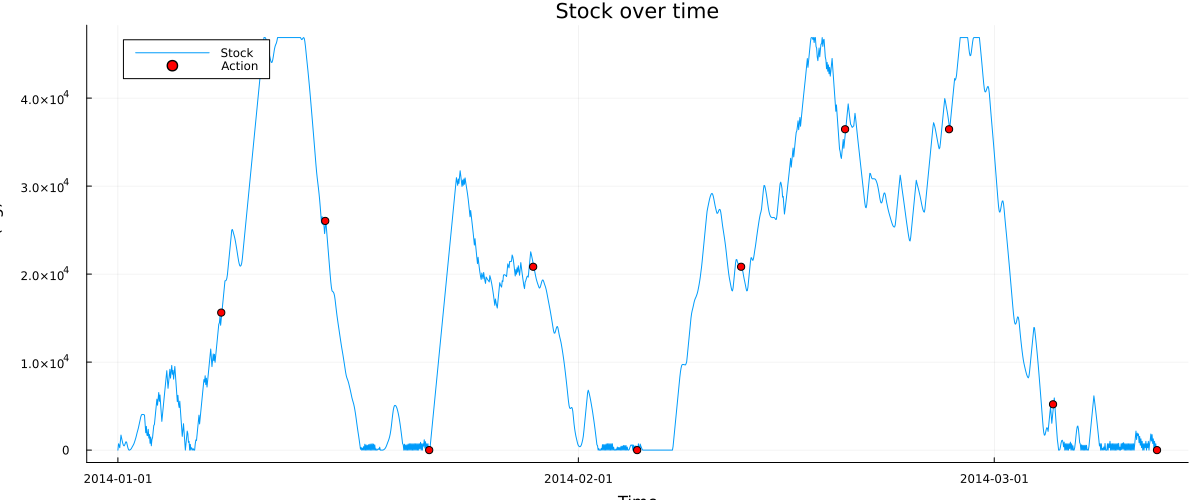

In [119]:
stock_plot = plot(size = (1200, 500), legend = :topleft,
    xlabel = "Time", ylabel = "Stock (Kg)", title = "Stock over time")
plot!(stock_plot, overall_time,
    output_simulation["stock"], label = "Stock") 
scatter!(stock_plot, last_hour_by_week, action_result_by_week, label = "Action", color = :red)

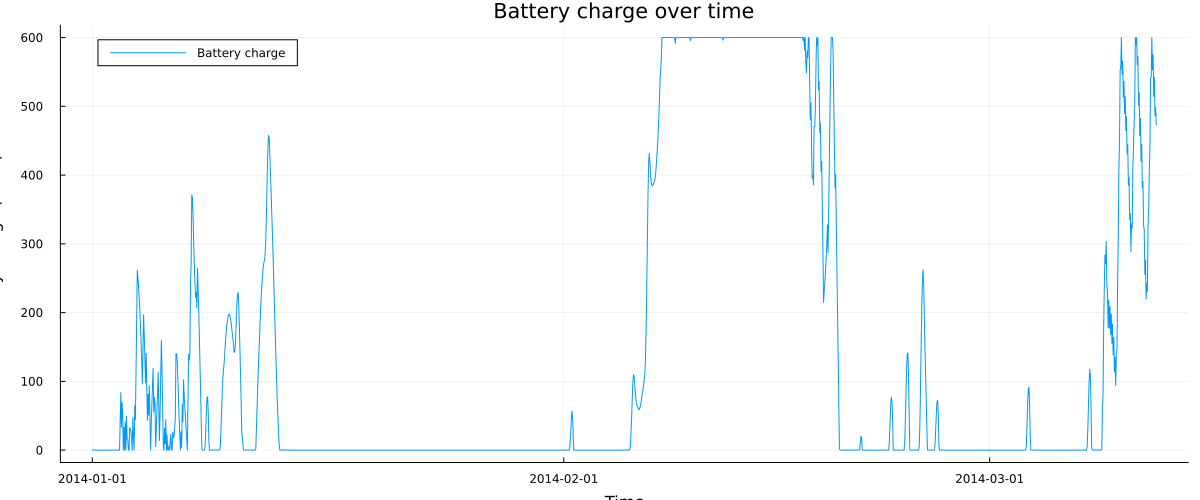

In [120]:
battery_plot = plot(size = (1200, 500), legend = :topleft,
    xlabel = "Time", ylabel = "Battery charge (MWh)", title = "Battery charge over time")
plot!(battery_plot, overall_time, output_simulation["charge"], label = "Battery charge")

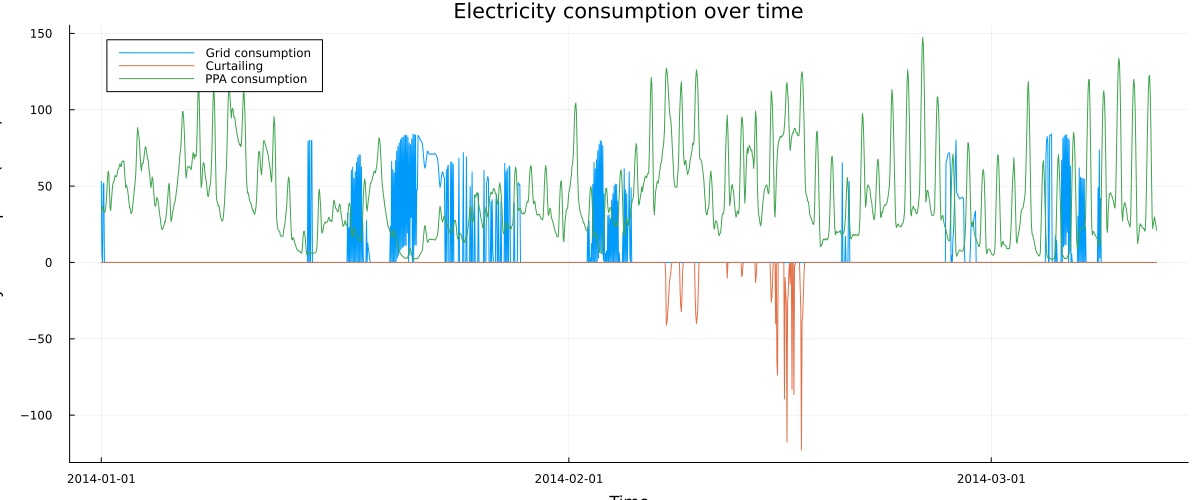

In [121]:
elec_plot = plot(size = (1200, 500), legend = :topleft,
    xlabel = "Time", ylabel = "Electricity consumption (MWh)", title = "Electricity consumption over time")
plot!(elec_plot, overall_time, output_simulation["elec_grid"], label = "Grid consumption")
plot!(elec_plot, overall_time, -output_simulation["curtailing"], label = "Curtailing")
plot!(elec_plot, overall_time, output_simulation["elec_ppa"], label = "PPA consumption")


## Compare with the MILP solution

In [ ]:
overall_wind = []
overall_solar = []

for t in 1:T
    append!(overall_wind, wind_by_week[t])
    append!(overall_solar, solar_by_week[t])
end

In [130]:
output = solve(
    overall_wind,
    overall_solar,
    DEMAND,
    wind_capa = WIND_CAPA,
    solar_capa = SOLAR_CAPA,
    battery_capa = BATTERY_CAPA,
    tank_capa = TANK_CAPA,
    electro_capa = ELECTRO_CAPA,
    initial_charge = initial_charge,
    initial_stock = initial_stock,
    final_charge = -1., # Battery is not constrained at the end
    final_stock = output_simulation["stock"][end],
)

MethodError: MethodError: no method matching solve(::Vector{Any}, ::Vector{Any}, ::Float64; wind_capa::Int64, solar_capa::Int64, battery_capa::Int64, tank_capa::Int64, electro_capa::Float64, initial_charge::Float64, initial_stock::Float64, final_charge::Float64, final_stock::Float64)

Closest candidates are:
  solve(!Matched::Vector{Float64}, !Matched::Vector{Float64}, ::Union{Float64, Int64}; gurobi_env, wind_capa, solar_capa, battery_capa, tank_capa, electro_capa, price_grid, price_curtailing, price_penality, capa_bat_upper, capa_elec_upper, ebat, fbat, eelec, cost_elec, cost_bat, cost_tank, cost_wind, cost_solar, initial_charge, initial_stock, final_charge, final_stock, verbose)
   @ Main ~/Documents/Prog/ProjetIMI/src/solver.jl:52
  solve(!Matched::Vector{Float64}, !Matched::Vector{Float64}, ::Any; gurobi_env, wind_capa, solar_capa, battery_capa, tank_capa, electro_capa, price_grid, price_curtailing, price_penality, capa_bat_upper, capa_elec_upper, ebat, fbat, eelec, cost_elec, cost_bat, cost_tank, cost_wind, cost_solar, initial_charge, initial_stock, final_charge, final_stock, verbose)
   @ Main ~/Documents/Prog/ProjetIMI/src/solver.jl:52
